In [1]:
import gensim
import scipy
import torch
import nltk
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from bertopic import BERTopic
from pymystem3 import Mystem
from nltk.corpus import stopwords
from tqdm import tqdm
tqdm.pandas()
import time
from typing import List

# Part 1  Первичный анализ данных и тематическое моделирование

In [3]:
path = 'D:\\datasets.csv'# путь к датасету
df = pd.read_csv(path) # DataFrame
df = df.drop('Unnamed: 0', axis=1) 

## EDA

In [5]:
# дубликаты
duplicates = df[df.duplicated()]
print("Дубликаты:")
print(duplicates)

# пропуски в каждом столбце
missing_values = df.isnull().sum()
print("\nПропущенные значения в каждом столбце:")
print(missing_values)


Дубликаты:
Empty DataFrame
Columns: [Unnamed: 0, text, sentiment]
Index: []

Пропущенные значения в каждом столбце:
Unnamed: 0    0
text          0
sentiment     0
dtype: int64


Пропуски и дубликаты в датасете отсутствуют

In [6]:
# уникальные тональности и их количество в столбце 'sentiment'
unique, counts = np.unique(df.sentiment.values, return_counts=True)

label_dict = {
            0: 'NEUTRAL',
            1: 'POSITIVE',
            2: 'NEGATIVE'
            }

unique = [label_dict[sentiment] for sentiment in unique]

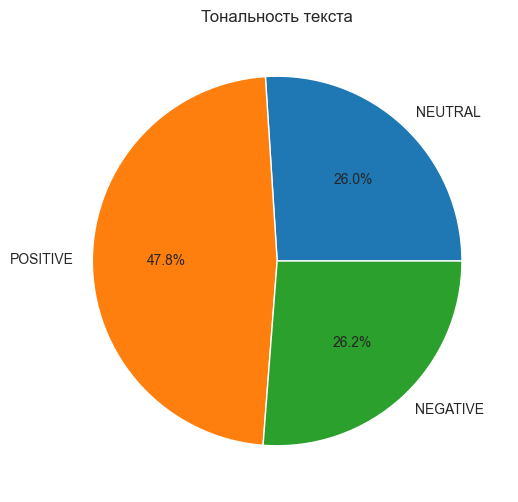

In [113]:
sns.set_style("whitegrid") # стиль графика
plt.figure(figsize=(6,6))
plt.pie(counts, labels=unique, autopct='%1.1f%%')
plt.title('Тональность текста')
plt.show()

Классы  сбалансированы, можно не уделять время компенсированию дисбаланса.

In [10]:
from langdetect import detect

def detect_language(text: str) -> str:
    """
    Определяет язык текста.

    Args:
        text (str): Текст для определения языка.

    Returns:
        str: Код языка, определенный для текста. 
             В случае ошибки возвращает "unknown".
    """    
    try:
        return detect(text)
    except:
        return "unknown"

In [11]:
# Применение функции к каждому тексту в датасете
df['language'] = df['text'].progress_apply(lambda x: detect_language(x))

100%|██████████| 210989/210989 [11:08<00:00, 315.57it/s]


In [12]:
# Подсчет частоты использования различных языков
language_counts = df['language'].value_counts()

print(language_counts)

language
ru         210408
bg            222
mk            140
uk             92
en             58
sl             18
hr             14
unknown        11
et              5
sk              4
vi              4
it              2
ro              2
sv              2
pt              2
id              1
no              1
de              1
ja              1
ca              1
Name: count, dtype: int64


In [29]:
non_russian_texts = df[df['language'] == 'hr']
non_russian_texts

,text,sentiment,length,language
40512,"Pio na4aly bilo super , no vse xoro6ee kogdato...",0,12,hr
54279,http: www.aspd.ru napravlenija dejatelnosti ak...,0,10,hr
59265,Doragie i yvajaemie xozaeva restoranta Biktori...,2,34,hr
64852,Bili s podrugoy . ochen ponravilas i kuhnya i ...,2,38,hr
68506,Tetya mozhet vi viydite iz obsuzhdeniya ? ! vi...,2,17,hr
73624,https: goo-gl.ru 4UPn\n,2,3,hr
89791,"Po otzivom drugix mogu sdelat ' vivod , chto u...",2,32,hr
97256,Restoran super ! Ochen domashniy & mili .. mi...,2,37,hr
97702,ZDRASTVUITE DOROGIE MOI ! GALINA NIKOLAEVNA I...,2,63,hr
116545,U Zagori na izvoru rijeke ikole Stala bra a da...,0,31,hr


Шум отличный по языку от русского, который вносит bias, его в дальнейшем можно удалить или исправить в русскую версию.

In [8]:
# Добавил 'length' чтобы в дальнейшем определить алгоритм для тематического моделировния
df['length'] = df.text.apply(lambda row: len(row.split()))

print(f'Mean length: {df['length'].mean()}')

Mean length:  120.73309035068179


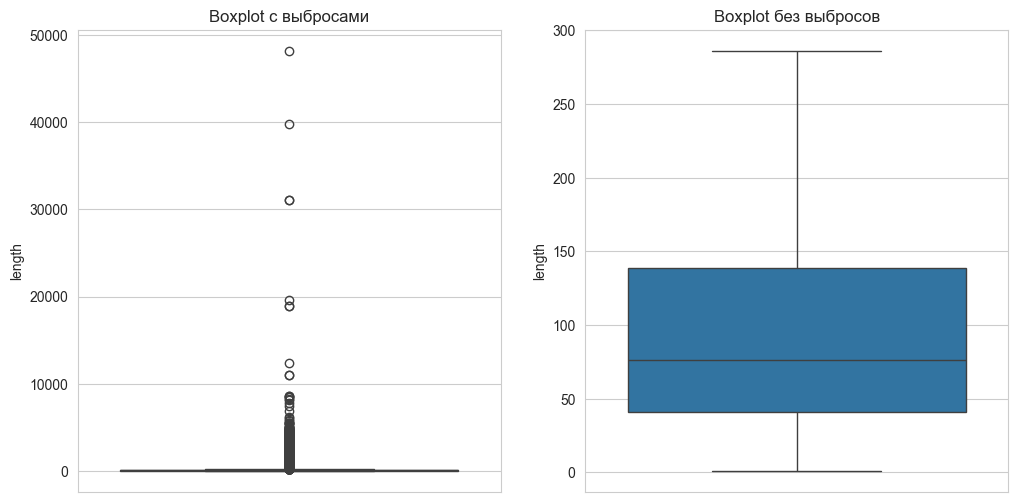

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot с выбросами
sns.boxplot(data=df['length'], ax=axes[0], showfliers=True)
axes[0].set_title('Boxplot с выбросами')

# Boxplot без выбросов
sns.boxplot(data=df['length'], ax=axes[1], showfliers=False)
axes[1].set_title('Boxplot без выбросов')
# Отображение графиков
plt.show()

## preprocessing

In [30]:
nltk.download("stopwords") # Загрузка стоп-слов
russian_stopwords  = stopwords.words('russian') # Стоп-слова для русского языка

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\badwh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
def preprocess_text(text: str) -> List[str]:
    """
    Предобрабатывает текст, выполняя следующие шаги:
    1. Преобразует текст в нижний регистр.
    2. Удаляет все знаки препинания, оставляя только буквы и пробелы.
    3. Разбивает текст на отдельные слова (токены).
    4. Удаляет стоп-слова из токенов.

    Args:
        text (str): Исходный текст.

    Returns:
        List[str]: Список токенов после предобработки.
    """
    text = text.lower()# Текст в нижний регистр
    text = re.sub(r'[^\w\s]', '', text) # Удаляем все знаки препинания
    tokens = text.split() # Разбиваем текст на отдельные слова (токены)
    tokens = [token for token in tokens if token not in russian_stopwords]
    
    return tokens

In [32]:
df['prepared_text'] = df['text'].apply(lambda x: preprocess_text(x))
df['str_text'] = df['prepared_text'].apply(lambda x: " ".join(x))

In [37]:
# Функция для лемматизации текста
def lem_text(text: str) -> str:
    """
    Лемматизирует заданный текст с использованием библиотеки pymystem3.

    Args:
        text (str): Исходный текст для лемматизации.

    Returns:
        str: Лемматизированный текст.
    """
    # Лемматизация текста
    lemmas = mystem.lemmatize(text)

    # Объединение лемматизированных слов в строку
    lemmatized_text = "".join(lemmas)

    return lemmatized_text

Основная задача лемматизации является обеспечение более точного анализа текста и уменьшение датасета.

Например слова красивый, красивая, красивое будут лемматизированы до красивый.


Проблема лемматизации с windows, https://github.com/nlpub/pymystem3/issues/29 

In [38]:
mystem = Mystem()
df['lemmatized_text'] = df['str_text'].progress_apply(lambda x: lem_text(x))


  0%|          | 13/210989 [00:06<30:01:43,  1.95it/s]


KeyboardInterrupt: 

## tematic modeling

Существует множество различных алгоритмов для тематического моделирования, однако я выбрал для рассмотрения два из них: LDA и BERTopic.

Плюсы LDA:
Большие и разнообразные корпуса текстов, результаты LDA легко интерпретировать, при работе не требуются огромные вычислительные ресурсы.

Плюсы BERTopic:
Подход, который использует трансформер для векторизации текста и объединяет его с техникой кластеризации для обнаружения тем.
Это позволяет ему понимать семантику и особенность текста.


Средняя длина текста составляет около 120 слов, поэтому классический подход LDA не будет эффективно работать с короткими текстами, такими как посты и сообщения на форумах.
Основной проблемой при использовании BERTopic являются высокие требования к вычислительным ресурсам. Однако, учитывая условия задания и небольшой объем данных, я решил выбрать именно BERTopic.


In [34]:
topic_model = BERTopic(
    language='russian', # Язык
    nr_topics=20,       # Количество тем
    verbose=True        # Вывод информации 
)

topic_model.fit(df['str_text'])

2024-07-03 19:43:24,147 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 6594/6594 [02:17<00:00, 48.10it/s]
2024-07-03 19:45:49,764 - BERTopic - Embedding - Completed ✓
2024-07-03 19:45:49,765 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-03 19:47:59,465 - BERTopic - Dimensionality - Completed ✓
2024-07-03 19:47:59,470 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-03 19:48:16,667 - BERTopic - Cluster - Completed ✓
2024-07-03 19:48:16,668 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-03 19:48:33,305 - BERTopic - Representation - Completed ✓
2024-07-03 19:48:33,321 - BERTopic - Topic reduction - Reducing number of topics
2024-07-03 19:48:50,153 - BERTopic - Topic reduction - Reduced number of topics from 843 to 20


In [35]:
topic_model.visualize_topics()

In [36]:
topic_model.visualize_hierarchy()

Выводы:

Определение тем прошло успешно, судя по графикам: основные кластеры четко отделены друг от друга, что указывает на ясное смысловое разграничение. В иерархии выделены темы, действительно схожие по семантической нагрузке.

Для дальнейшего улучшения тематического моделирования:

1) добавить лемматизацию (на Windows у библиотеки есть проблемы)
2) n-gramm для расширения словаря (new york -> new_york)
3) расширить список stopwords
4) убрать ссылки из данных
5) убрать шумные данные (текст на иностранном языке)
6) настроить гиперпараметры модели


# 2 part  Обучение классификатора

In [53]:
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoConfig, AdamW
from typing import Dict
import gc
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

Дообучать для классификации буду cointegrated/rubert-tiny2.

Функция потерь - используемая моделью по умолчанию кросс-энтропийная функция - стандартный выбор для задач классификации вроде определения тональности текста. Она обладает хорошими вычислительными свойствами и наказывает модель более сильно за уверенные и неправильные предсказания, что позволяет строить точные классификаторы.

Метрика качества -  F1 ее можно интерпретировать как среднее гармоническое значение точности и полноты, где показатель F1 достигает своего наилучшего значения при 1, а худшего — при 0.

In [78]:
train_data = pd.DataFrame()
train_data['text'] = df['text'].str.lower()
train_data['text'] = train_data['text'].apply(lambda x: x.replace('\n', ' '))
train_data['sentiment'] = df['sentiment']

In [82]:
class SentimentDataset(Dataset):
    """
    Класс датасета для задачи анализа тональности текста.
    """
    def __init__(self, dataframe, tokenizer, max_seq_len):
        """
        Инициализация датасета.

        Args:
            dataframe (pd.DataFrame): DataFrame с колонками 'text' (тексты для анализа) и 'sentiment' (метки тональности).
            tokenizer (PreTrainedTokenizer): Токенизатор модели.
            max_seq_len (int): Максимальная длина последовательности после токенизации и паддинга.
        """
        self.text = dataframe['text'].tolist()
        self.targets = None

        if 'sentiment' in dataframe:
            self.targets = dataframe['sentiment'].tolist() # Список таргетов, если они есть

        self.tokenizer = tokenizer # Токенизатор
        self.max_seq_len = max_seq_len # Максимальная длина последовательности после токенизации и паддинга
        
        self.encode = tokenizer.batch_encode_plus(
            self.text,
            padding='max_length',
            max_length=self.max_seq_len,
            truncation=True,
            return_attention_mask=True
        )

    def __getitem__(self, i):
        """
        Получение элемента датасета по индексу.

        Args:
            i (int): Индекс элемента в датасете.

        Returns:
            tuple: Кортеж с токенизированными и закодированными данными и таргетом (если есть).
        """        
        input_ids = torch.tensor(self.encode['input_ids'][i], dtype=torch.long)
        attention_mask = torch.tensor(self.encode['attention_mask'][i], dtype=torch.long)
        if self.targets is not None:
          targets = self.targets[i]
          return (input_ids, attention_mask, targets) # Токены и маски, таргеты
        else:
          return (input_ids, attention_mask) # Токены и маски

    def __len__(self) -> int:
        """
        Получение длины датасета.

        Returns:
            int: Количество элементов в датасете.
        """        
        return len(self.text)

In [83]:
MAX_LEN = 300 # Максимальная длина последовательности
BATCH_SIZE = 12 # Размер батча для DataLoader

# Данный токенизатор был обучен конкретно на корпусе русского текста
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

# Разделение набора данных на 0.8 0.1 0.1
train_split, val_split = train_test_split(train_data, test_size=0.2)
val_split, test_data = train_test_split(val_split, test_size=0.5)

# Датасеты
train_dataset = SentimentDataset(train_split, tokenizer, MAX_LEN)
val_dataset = SentimentDataset(val_split, tokenizer, MAX_LEN)
test_dataset = SentimentDataset(test_data, tokenizer, MAX_LEN)


# Параметры для DataLoader
train_params = {"batch_size": BATCH_SIZE,
                "shuffle": True,
                "num_workers": 0
                }

val_params = {"batch_size": BATCH_SIZE,
                "shuffle": False,
                "num_workers": 0
                }

test_params = {"batch_size": BATCH_SIZE,
               "shuffle": False,
               "num_workers": 0
               }

# DataLoader
train_dataloader = DataLoader(train_dataset, **train_params)
val_dataloader = DataLoader(val_dataset, **val_params)
test_dataloader = DataLoader(test_dataset, **test_params)

In [57]:
class ModelForClassification(torch.nn.Module):

    def __init__(self, model_name: str, config: Dict):
        super(ModelForClassification, self).__init__()
        """
        Инициализация модели для классификации текстов с использованием предобученной модели BERT.

        Args:
            model_name (str): Имя предобученной модели BERT, которую нужно загрузить.
            config (Dict): количество классов (num_classes)
                           коэффициент dropout (dropout_rate).

        """
        self.n_classes = config['num_classes'] # Количество классов для классификации
        self.dropout_rate = config['dropout_rate'] # Коэффициент dropout для регуляризации

        # Загрузка конфигурации  
        bert_base_config = AutoConfig.from_pretrained(model_name)
        # Загрузка модели  
        self.bert = AutoModel.from_pretrained(model_name,
                                              config=bert_base_config)
        
        # Линейный слой
        self.pre_classifier = torch.nn.Linear(bert_base_config.hidden_size,
                                              bert_base_config.hidden_size,)
        # Финальный слой
        self.classifier = nn.Linear(bert_base_config.hidden_size,
                                        self.n_classes)
        # Dropout для регуляризации
        self.dropout = torch.nn.Dropout(self.dropout_rate)


    def forward(self, input_ids, attention_mask,):
        """
        Прямой проход

        Args:
            input_ids (torch.Tensor): Тензор с идентификаторами токенов.
            attention_mask (torch.Tensor): Тензор маски внимания для учета паддингов.

        Returns:
            torch.Tensor: Тензор с предсказанными logits для каждого класса.
        """

        # Проход через BERT
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Получение скрытого состояния (первого токена CLS)
        hidden_state = output[0]
        # Выбираем только первый токен (CLS)
        hidden_state = hidden_state[:, 0] 

        hidden_state = self.pre_classifier(hidden_state)
        hidden_state = torch.nn.ReLU()(hidden_state)
        # Dropout для регуляризации
        hidden_state = self.dropout(hidden_state)
        # Классификация
        output = self.classifier(hidden_state)
        
        return output

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  #(GPU или CPU)
config = {
    "num_classes": 3,   # Количество классов
    "dropout_rate": 0.1 #  dropout
}

model_name = "cointegrated/rubert-tiny2" # Имя предобученной BERT

# Создание  модели для классификации
model = ModelForClassification(
    model_name,
    config=config
)

model.to(device)

ModelForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, element

In [59]:
optimizer = AdamW(model.parameters(), lr=1e-05) # Оптимизатор
criteron = nn.CrossEntropyLoss() # CrossEntropyLoss для многоклассовой классификации

In [84]:
N_EPOCH = 2         # Количество эпох обучения
total_loss = []     # loss на обучении

for epoch in range(N_EPOCH):
    model.train()
    epoch_loss = [] # loss в текущей эпохе

    for input_ids, attention_mask, target in tqdm(train_dataloader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        y_pred = model(input_ids, attention_mask)

        loss = criteron(y_pred, target)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

    input_ids = input_ids.to(torch.device('cpu'))
    attention_mask = attention_mask.to(torch.device('cpu'))
    target = target.to(torch.device('cpu'))
    gc.collect()

    f1_score_list = []      # F1-score на валидации

    # Оценка модели на валидации
    with torch.no_grad():
      model.eval()
      val_loss = []
      for input_ids, attention_mask, target in tqdm(val_dataloader):
          target = target.to(device)
        
          input_ids = input_ids.to(device)
          attention_mask = attention_mask.to(device)

          y_pred = model(input_ids, attention_mask)
          loss = criteron(y_pred, target)

          val_loss.append(loss.item())

          _, y_pred = torch.max(y_pred, -1)
          f1 = f1_score(target.tolist(), y_pred.tolist(), average='weighted')
          f1_score_list.append(f1)

    # Вычисление средней потери на обучении и валидации за текущую эпоху
    v_loss = sum(val_loss)/len(val_loss)
    el = sum(epoch_loss)/len(epoch_loss)
    total_loss.append(el)

    # Вычисление среднего F1-score на валидации за текущую эпоху
    f1 = np.array(f1_score_list).mean()
    
    # Вывод результатов текущей эпохи обучения
    print("Epoch:", epoch+1, "-- loss:", el, "-- val loss:", v_loss, "-- f1:", f1)

100%|██████████| 792/792 [00:08<00:00, 98.84it/s] 


Epoch: 1 -- loss: 0.5672925962545953 -- val loss: 0.49148704540548904 -- f1: 0.7747958687357627


100%|██████████| 792/792 [00:07<00:00, 99.50it/s] 

Epoch: 2 -- loss: 0.46121921847800035 -- val loss: 0.4541016046635129 -- f1: 0.7938814245407361


In [88]:
def get_time_and_f1(model, device):
    """
    Функция для измерения времени инференса и вычисления среднего F1-score на тестовом наборе данных.

    Args:
        model (torch.nn.Module): Обученная модель для классификации.
        device (torch.device): Устройство, на котором происходит вычисление (GPU или CPU).

    Returns:
        float: Среднее время инференса в миллисекундах.
        float: Средний F1-score на тестовом наборе данных.
    """    
    time_scores, f1_scores = [], []
    
    model.to(device)

    model.eval()

    for input_ids, attention_mask, target in tqdm(test_dataloader):
        target = target.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        
        # Измерение времени инференса
        start = time.time()
        y_pred = model(input_ids, attention_mask) # Предсказание модели
        finish = time.time()

        # Вычисление F1-score
        _, y_pred = torch.max(y_pred, -1)
        f1 = f1_score(target.tolist(), y_pred.tolist(), average='weighted')
        f1_scores.append(f1)

        # Измерение времени инференса в миллисекундах
        res = finish - start
        res_msec = res * 1000   # Преобразование в миллисекунды
        time_scores.append(res_msec)

    return(np.mean(time_scores), np.mean(f1_scores))


In [91]:
# Оценка модели на устройстве 'cuda' (GPU)
device = 'cuda' 
time_scores, f1_scores = get_time_and_f1(model, device)
print(f'device:{device} мс:{np.round(time_scores, 4)} f1:{np.round(f1_scores, 4)}')


# Оценка модели на устройстве 'cpu'
device = 'cpu'
time_scores, f1_scores = get_time_and_f1(model, device)
print(f'device:{device} мс:{np.round(time_scores, 4)} f1:{np.round(f1_scores, 4)}')

100%|██████████| 88/88 [00:01<00:00, 76.58it/s]


device:cuda мс:2.7251 f1:0.7867


100%|██████████| 88/88 [00:32<00:00,  2.74it/s]

device:cpu мс:361.1488 f1:0.7867


Выводы:

Скорость работы модели на GPU заметно выше чем на CPU (361 мс > 2.72 мс)

Обчучение и классификация прошла успешно, по метрике f1 качество на тестовой выборке == 0.7867, переобучение не произошло (лосс на валидации продолжил падать)

Для дальнейшего улучшения модели и кода:

1) нужно посмотреть confusion matrix, чтобы понять на каких примерах модель чаще ошибается
2) провести подбор гиперпараметров модели
3) добавить графики для логгирования экспериментов
4) перенести конфиги модели и запуска обучения в json или yaml файл


# part 3 Оптимизация классификатора

Для оптимизации предобученной модели для инференса на CPU можно:

1) Провести квантизацию - преобразование весов модели и активаций с 32-битной точности до 8-битной.
Это позволяет значительно уменьшить размер модели и ускорить ее выполнение на CPU

2) Выбрать оптимизированную библиотеку для инференса. ONNX Runtime, OpenVINO, TensorRT

В моем случае, quantize_dynamic из torch.quantization не получилось сделать без ошибок, поэтому я выбрал ONNX Runtime для инференса на cpu.

In [95]:
import onnx
import onnxruntime
# Подготовка примерного входного текста и токенизация
text = "Хочу пива"
dumy_input = tokenizer(text, return_tensors="pt")

In [100]:
# Экспорт модели в формат ONNX
torch.onnx.export(
    model, 
    (dumy_input['input_ids'], dumy_input['attention_mask']),  # Входные данные
    "bert_m.onnx",  # Имя файла для сохранения модели
    export_params=True,  # Экспортируем вместе с параметрами модели
    input_names=['input_ids', 'attention_mask', 'token_type_ids'],  # Имена входных слоев
    output_names=['output'],  # Имена выходных слоев
    dynamic_axes={  # variable length axes
        'input_ids': {0: 'batch_size', 1: 'sequence_length'},
        'attention_mask': {0: 'batch_size', 1: 'sequence_length'},
        'token_type_ids': {0: 'batch_size', 1: 'sequence_length'},
        'output': {0: 'batch_size'}
    }
)

In [110]:
# Подготовка входных данных для ONNX модели
def to_numpy(tensor):
    """
    Функция для преобразования тензора PyTorch в массив NumPy.

    Args:
        tensor (torch.Tensor): Входной тензор.

    Returns:
        np.ndarray: Результат в виде массива NumPy.
    """    
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


def get_time_and_f1_onnx(ort_session, device):
    """
    Функция для измерения времени инференса и вычисления среднего F1-score для ONNX модели.

    Args:
        ort_session (onnxruntime.InferenceSession): Сессия ONNX для инференса модели.
        device (torch.device): Устройство, на котором происходит вычисление (GPU или CPU).

    Returns:
        float: Среднее время инференса в миллисекундах.
        float: Средний F1-score на тестовом наборе данных.
    """      
    time_scores, f1_scores = [], []

    for input_ids, attention_mask, target in tqdm(test_dataloader):
        target = target.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        ort_inputs = {
            'input_ids': to_numpy(input_ids),
            'attention_mask': to_numpy(attention_mask)
        }

        # Измерение времени инференса
        start = time.time()
        ort_outs = ort_session.run(None, ort_inputs)
        finish = time.time()

        y_pred = torch.tensor(ort_outs[0])
        _, y_pred = torch.max(y_pred, -1)
        f1 = f1_score(target.tolist(), y_pred.tolist(), average='weighted')
        f1_scores.append(f1)

        res = finish - start
        res_msec = res * 1000
        time_scores.append(res_msec)

    return np.mean(time_scores), np.mean(f1_scores)

In [111]:
device = 'cpu'
# Загрузка ONNX модели
ort_session = onnxruntime.InferenceSession("bert_m.onnx")
# Оценка времени инференса и F1-score для ONNX модели на CPU
time_scores, f1_scores = get_time_and_f1_onnx(ort_session, device)
print(f'device:{device} мс:{np.round(time_scores, 4)} f1:{np.round(f1_scores, 4)}')

100%|██████████| 88/88 [00:08<00:00, 10.45it/s]

device:cpu мс:92.3102 f1:0.7867


Выводы:

В результате использования ONNX, скорость работы на CPU выросла в 4 раза без потери качества.

|                | мс time  | f1     |  
|----------------|----------|--------|
| onnx_model_cpu | 92.3102  | 0.7867 |
| model_cpu      | 361.1488 | 0.7867 |  
| model_cuda     | 2.7251   | 0.7867 | 

Для дальнейшего ускорения можно выполнить:

1) Дистилляцию - использование предсказаний большой модели для передачи информации на модель с меньшим числов весов.
2) Квантизация - преобразование весов и активаций модели из float32 в более компактные форматы, такие как int8.
3) Прунинг - удаление незначимых весов модели.


